In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import math
import keras
from keras.layers import LSTM, Dense, Activation, Input
from tensorflow.keras.optimizers import Adam
from keras.layers import Layer
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
name_month_revenue = pd.read_csv("./name_month_revenue.csv")
revenue_by_month = pd.read_csv("./revenue_by_month.csv")
name_month_revenue.shape, revenue_by_month.shape 

((44, 255), (44, 2))

# Train a rnn model with LSTM gate unit.

Using all the 255 songs

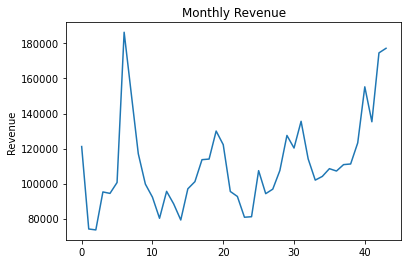

In [3]:
song_total_revenue = np.sum(name_month_revenue.values[:,1:],axis=1).astype("float32")

plt.plot(song_total_revenue)
plt.ylabel('Revenue')
plt.title("Monthly Revenue")
plt.show()

We need to process the dataset to feed RNN input layer. We change data in this way:
$$[x_0,x_1,x_2,x_3,x_4,x_5,...]$$ 
to:
$$\begin{aligned}
&[[x_0,x_1,x_2,x_3,x_4],\\ 
&[x_1,x_2,x_3,x_4,x_5]] 
\end{aligned}$$

Epoch 1/100
29/29 - 1s - loss: 0.0700 - 752ms/epoch - 26ms/step
Epoch 2/100
29/29 - 0s - loss: 0.0359 - 17ms/epoch - 586us/step
Epoch 3/100
29/29 - 0s - loss: 0.0305 - 19ms/epoch - 655us/step
Epoch 4/100
29/29 - 0s - loss: 0.0271 - 19ms/epoch - 655us/step
Epoch 5/100
29/29 - 0s - loss: 0.0258 - 20ms/epoch - 690us/step
Epoch 6/100
29/29 - 0s - loss: 0.0242 - 19ms/epoch - 655us/step
Epoch 7/100
29/29 - 0s - loss: 0.0257 - 20ms/epoch - 690us/step
Epoch 8/100
29/29 - 0s - loss: 0.0254 - 19ms/epoch - 655us/step
Epoch 9/100
29/29 - 0s - loss: 0.0233 - 21ms/epoch - 724us/step
Epoch 10/100
29/29 - 0s - loss: 0.0239 - 20ms/epoch - 690us/step
Epoch 11/100
29/29 - 0s - loss: 0.0244 - 20ms/epoch - 690us/step
Epoch 12/100
29/29 - 0s - loss: 0.0262 - 21ms/epoch - 724us/step
Epoch 13/100
29/29 - 0s - loss: 0.0235 - 19ms/epoch - 655us/step
Epoch 14/100
29/29 - 0s - loss: 0.0229 - 19ms/epoch - 655us/step
Epoch 15/100
29/29 - 0s - loss: 0.0223 - 19ms/epoch - 655us/step
Epoch 16/100
29/29 - 0s - loss: 0.

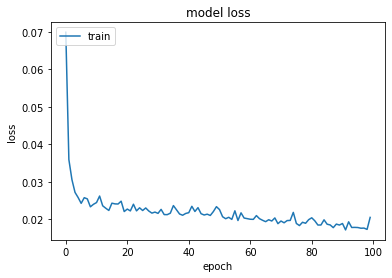

In [4]:
df = pd.DataFrame(song_total_revenue)

df=np.array(df)

train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df[0:train_size,:], df[train_size:len(df),:]

def create_dataset(df, previous=1):
    dataX, dataY = [], []
    for i in range(len(df)-previous-1):
        a = df[i:(i+previous), 0]
        dataX.append(a)
        dataY.append(df[i + previous, 0])
    return np.array(dataX), np.array(dataY)

scaler = MinMaxScaler(feature_range=(0, 1))
train_01 = scaler.fit_transform(train)

# Lookback period
lookback = 5
X_train, Y_train = create_dataset(train_01, lookback)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

# Generate LSTM network
model = tf.keras.Sequential()
model.add(LSTM(80, input_shape=(1, lookback)))
model.add(Dense(32,"tanh"))
model.add(Dense(1,"tanh"))
model.compile(loss='mean_squared_error', optimizer='adam')
history=model.fit(X_train, Y_train, epochs=100, batch_size=1, verbose=2)

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Take a look at model structure.

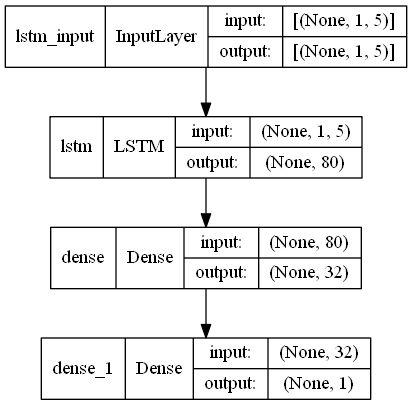

In [5]:
tf.keras.utils.plot_model(model, to_file='Model.png', show_shapes=True)

In [6]:
trainpred = model.predict(X_train)# 0-1
trainpred_n = scaler.inverse_transform(trainpred)
Y_train_n = scaler.inverse_transform([Y_train])
# Train predictions
trainpredPlot = np.empty_like(df)
trainpredPlot[:, :] = np.nan
trainpredPlot[lookback:len(trainpred_n)+lookback, :] = trainpred_n

X_test, Y_test = create_dataset(scaler.fit_transform(test), lookback) 
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
testpred = model.predict(X_test) 
testpred_n = scaler.inverse_transform(testpred)
Y_test_n = scaler.inverse_transform([Y_test])

# test predictions
testpredPlot = np.empty_like(df)
testpredPlot[:, :] = np.nan
testpredPlot[len(trainpred_n)+(lookback*2)+1:len(df)-1, :] = testpred_n

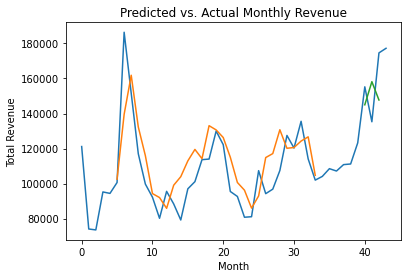

In [7]:
inversetransform2, =plt.plot(df)
trainpred2, =plt.plot(trainpredPlot)
testpred2, =plt.plot(testpredPlot)
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.title("Predicted vs. Actual Monthly Revenue")
plt.show()

The orange curve is fitting curve of training set. It fits pattern well. Our model roughly fits the trend but fails on making precious numerical results at the first peak. Several surges dominate the blue curve, since some outliers affect the revenue curve extremely. Actually, the four most popular songs contribute a lot of income. 

![Most Popular Songs](./revenue_song_month.png)

This is a scattorplot showing the total income of each songs 

## Exclude most four popular songs.

"Count Me In"        "Falling into Place" "Free Rein"          "In the Moment" , we have 251 songs now. 

In [8]:
# exclude those popular songs
# "Count Me In"        "Falling into Place"   "Free Rein"          "In the Moment"   
normal_song_name = list(name_month_revenue.keys())
normal_song_name.remove("Count Me In" )
normal_song_name.remove("Falling into Place")
normal_song_name.remove("Free Rein")
normal_song_name.remove("In the Moment")

(44,)


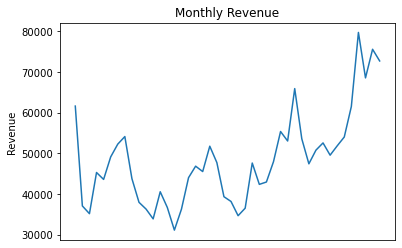

In [9]:
normal_song_revenue = name_month_revenue[normal_song_name]
normal_song_total_revenue = np.sum(normal_song_revenue.values[:,1:],axis=1).astype("float32")
print(normal_song_total_revenue.shape)

plt.plot(normal_song_total_revenue)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.ylabel('Revenue')
plt.title("Monthly Revenue")
plt.show()

In [10]:
df1 = pd.DataFrame(normal_song_total_revenue)

df1=np.array(df1)
print(df1.shape)

train_size = int(len(df1) * 0.8)
test_size = len(df1) - train_size
train, test = df1[0:train_size,:], df1[train_size:len(df1),:]

scaler = MinMaxScaler(feature_range=(0, 1))
train_01 = scaler.fit_transform(train)

# Lookback period
lookback = 5
X_train, Y_train = create_dataset(train_01, lookback)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

print(X_train.shape, Y_train.shape)

(44, 1)
(29, 1, 5) (29,)


Epoch 1/100
29/29 - 1s - loss: 0.0948 - 754ms/epoch - 26ms/step
Epoch 2/100
29/29 - 0s - loss: 0.0472 - 17ms/epoch - 586us/step
Epoch 3/100
29/29 - 0s - loss: 0.0433 - 18ms/epoch - 621us/step
Epoch 4/100
29/29 - 0s - loss: 0.0400 - 18ms/epoch - 621us/step
Epoch 5/100
29/29 - 0s - loss: 0.0353 - 19ms/epoch - 655us/step
Epoch 6/100
29/29 - 0s - loss: 0.0326 - 19ms/epoch - 655us/step
Epoch 7/100
29/29 - 0s - loss: 0.0313 - 21ms/epoch - 724us/step
Epoch 8/100
29/29 - 0s - loss: 0.0293 - 22ms/epoch - 759us/step
Epoch 9/100
29/29 - 0s - loss: 0.0272 - 22ms/epoch - 759us/step
Epoch 10/100
29/29 - 0s - loss: 0.0284 - 23ms/epoch - 793us/step
Epoch 11/100
29/29 - 0s - loss: 0.0260 - 22ms/epoch - 759us/step
Epoch 12/100
29/29 - 0s - loss: 0.0277 - 24ms/epoch - 828us/step
Epoch 13/100
29/29 - 0s - loss: 0.0264 - 21ms/epoch - 724us/step
Epoch 14/100
29/29 - 0s - loss: 0.0271 - 22ms/epoch - 759us/step
Epoch 15/100
29/29 - 0s - loss: 0.0261 - 22ms/epoch - 759us/step
Epoch 16/100
29/29 - 0s - loss: 0.

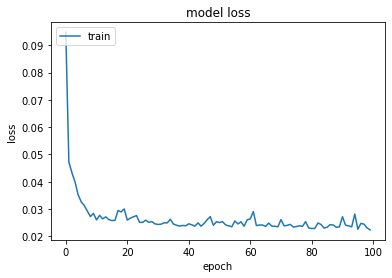

In [11]:
# Generate LSTM network
model = tf.keras.Sequential()
model.add(LSTM(80, input_shape=(1, lookback)))
model.add(Dense(32,"tanh"))
model.add(Dense(1,"tanh"))
model.compile(loss='mean_squared_error', optimizer='adam')
# history=model.fit(X_train, Y_train, validation_split=0.1, epochs=100, batch_size=1, verbose=2)
history=model.fit(X_train, Y_train, epochs=100, batch_size=1, verbose=2)

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [12]:
X_test, Y_test = create_dataset(scaler.fit_transform(test), lookback) 
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

testpred = model.predict(X_test)    
testpred_n = scaler.inverse_transform(testpred)
Y_test_n = scaler.inverse_transform([Y_test])

# test predictions
testpredPlot = np.empty_like(df1)
testpredPlot[:, :] = np.nan
testpredPlot[len(trainpred_n)+(lookback*2)+1:len(df1)-1, :] = testpred_n

train_01 = scaler.fit_transform(train)
X_train, Y_train = create_dataset(train_01, lookback)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
trainpred = model.predict(X_train)# 0-1
trainpred_n = scaler.inverse_transform(trainpred)
Y_train_n = scaler.inverse_transform([Y_train])
# Train predictions
trainpredPlot = np.empty_like(df1)
trainpredPlot[:, :] = np.nan
trainpredPlot[lookback:len(trainpred_n)+lookback, :] = trainpred_n

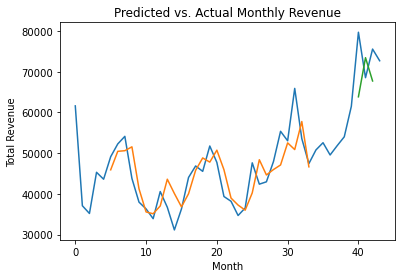

In [13]:
inversetransform2, =plt.plot(df1)
trainpred2, =plt.plot(trainpredPlot)
testpred2, =plt.plot(testpredPlot)
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.title("Predicted vs. Actual Monthly Revenue")
plt.show()

By excluding the four most popular songs, the model gives a better fit on training set. Experiments show that the revenue curve is sensitive to outliers, which may depend on a change of marketing strategies or a good performance of artists. In conclusion, a few popular songs (4 songs in our case) could cause a significant effect on total revenue (compared to other 251 songs). 